In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 이미지 불러오기

In [2]:
train = "./data/train"
test = "./data/test"
labels = pd.read_csv('./data/Training_set.csv')
labels_test=pd.read_csv('./data/Testing_set.csv')

In [3]:
print(labels.shape)

(6499, 2)


*   train -> 학습시킬 이미지
*   test -> 테스트 돌릴 이미지
*   labels -> 학습이미지 레이블
*   labels_test-> 테스트 이미지 레이블

### CNN알고리즘 수행

In [4]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

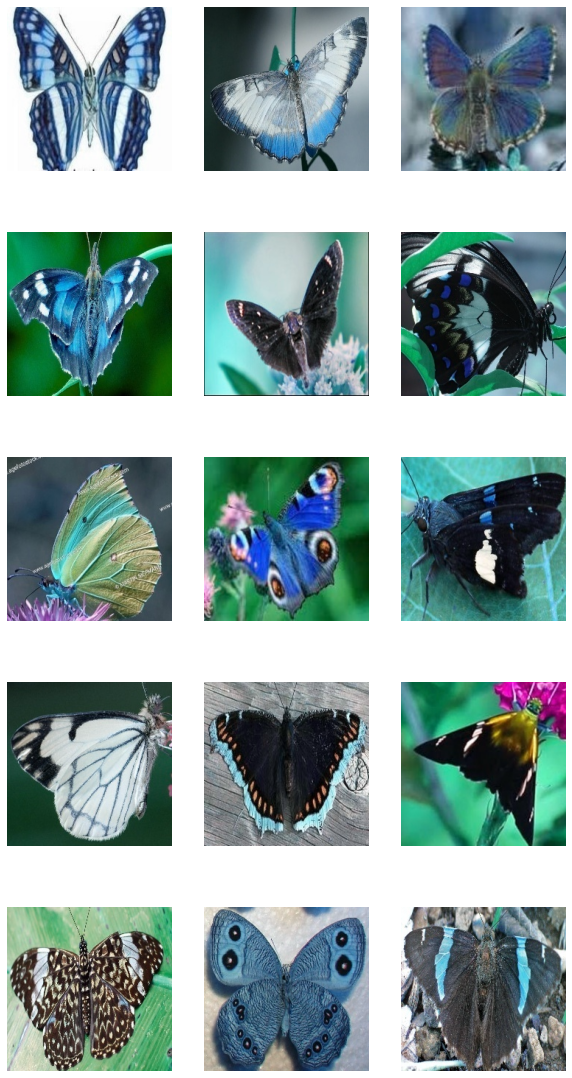

In [5]:
# 무작위로 train폴더 내의 샘플 이미지 표시 (15개)
example_images = random.sample(os.listdir(train), 15)

fig = plt.figure(figsize=(10,20))
for i, im in enumerate(example_images):
    plt.subplot(5, 3, i+1)
    im = cv2.imread(os.path.join(train, im))
    plt.imshow(im)
    plt.axis('off')
plt.show()

In [6]:
# train을 학습용과 실전용으로 분리 (8:2)
validation_split = 0.8
idxs = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[idxs]
val_labels = labels[~idxs]
print(len(train_labels), len(val_labels))

5200 1299


In [7]:
batch_size = 64
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=5,
    shear_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_labels,
    directory=train,x_col='filename',
    y_col='label',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)
val_generator = train_datagen.flow_from_dataframe(
    val_labels,
    directory=train,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.


In [8]:
# 텐서플로우에서 제공하는 Inception V3모델을 통해 분류
base_model = tf.keras.applications.InceptionV3(input_shape=(150,150,3),include_top=False,weights="imagenet")

In [9]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(75, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 75)                9675      
Total params: 24,188,395
Trainable params: 2,385,803
Non-trainable params: 21,802,592
____________________________________

In [10]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),  
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

In [12]:
lrd = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    factor = 0.50,
    min_lr = 1e-6
)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(
    verbose=1,
    patience=3
)

In [13]:
model.compile(optimizer='nadam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [14]:
# 학습 시작
%time
history=model.fit(train_generator,validation_data=val_generator,epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/20
82/82 [==============================] - 123s 1s/step - loss: 4.2632 - accuracy: 0.0385 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5852 - f1_score: 0.0000e+00 - val_loss: 4.0765 - val_accuracy: 0.0701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7010 - val_f1_score: 0.0000e+00
Epoch 2/20
82/82 [==============================] - 35s 426ms/step - loss: 3.9107 - accuracy: 0.0921 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7526 - f1_score: 0.0000e+00 - val_loss: 3.6413 - val_accuracy: 0.1263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8353 - val_f1_score: 0.0000e+00
Epoch 3/20
82/82 [==============================] - 36s 433ms/step - loss: 3.5067 - accuracy: 0.1340 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8487 - f1_score: 0.0000e+00 - val_loss: 3.2853 - val_accuracy: 0.1570 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8724 - val_f1_score: 0.0000e+00
Epoch 4/20
82/82 

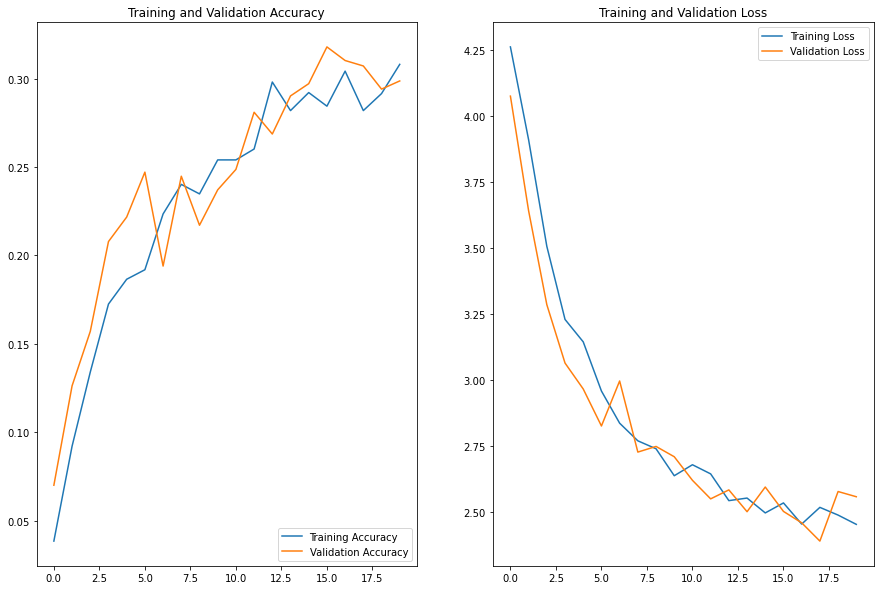

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# 진짜 실전용 데이터 투입
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_dataframe(
    labels_test,
    directory=test,
    x_col='filename',
    class_mode=None,
    batch_size=batch_size,
    target_size=(150,150)
)

Found 2786 validated image filenames.


In [17]:
result = np.argmax(model.predict(test_generator), axis = 1)
print(result)

[67 74 46 ... 14 33 13]


In [19]:
y_pred = pd.DataFrame((model.predict(test_generator) > 0.5).astype("int32"))
y_pred['filename']=labels_test['filename']

In [20]:
y_pred

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,filename
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_1.jpg
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_2.jpg
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_3.jpg
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_4.jpg
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_5.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_2782.jpg
2782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_2783.jpg
2783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_2784.jpg
2784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Image_2785.jpg
